In [74]:
import os, sys
import glob
currentdir = os.path.dirname(os.path.realpath('testing_pipeline.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from importlib import reload  
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

from src import pipeline
pipeline = reload(pipeline)

In [75]:
# very complicated way to plot
# https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


In [76]:
# Custom Keras layer

class SpaceToDepth(tf.keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'block_size': self.block_size,
        })
        return config

# Unet Mask

In [105]:
path = '../data/stacking/210311_stacked/cut_imgs/'
unet_model = '../data/weights/model_unet_checkpoint.h5'
yolo2_model = '../data/weights/yolo2_model.h5'
input_img = '../data/stacking/SCAN_2021-03-05_15-50-16/2021-03-05_15-50-16_0_0_5578.jpeg'
org_img_paths = glob.glob('../data/stacking/210311_stacked/*.jpeg')
output_dir_cells = '../data/stacking/210311_stacked/cells/'
output_dir_cut = '../data/stacking/210311_stacked/cut_imgs/'
slice_height = 1280
slice_width = 1280

In [78]:
org_img_paths

[]

In [79]:
pipeline.slice_img(input_img, output_dir_cut, resize_factor = 1,
                  slice_height = slice_height, slice_width = slice_width,
                  zero_frac_tresh = 0.8, overlap = 0, pad = 0, verbose = True)

Directory  ../data/stacking/210311_stacked/cut_imgs/  Created 
dx 1280
dy 1280
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_0_1280_1280_0.png
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_1280_1280_1280_0.png
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0.png
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_0_1280_1280_0.png
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_1280_1280_1280_0.png
image output: ../data/stacking/210311_stacked/cut_imgs/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_2000_1280_1280_0.png
Num slices: 6 Num non-null slices: 0 sliceHeight 1280 sliceWidth 1280


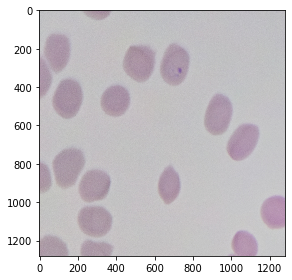

In [80]:
imgs, sizes_imgs, paths_imgs = pipeline.get_imgs(path, img_height = slice_height, img_width = slice_width, img_channels = 3)
imshow(imgs[0])

In [81]:
imgs[0].shape

(1280, 1280, 3)

In [82]:
img_height = 256
img_width = 256
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [83]:
sizes_imgs_red

[[256, 256], [256, 256], [256, 256], [256, 256], [256, 256], [256, 256]]

In [84]:
pred_masks_t = pipeline.unet_predict(unet_model, imgs_red)

1/1 [==============================] - 1s 1s/step



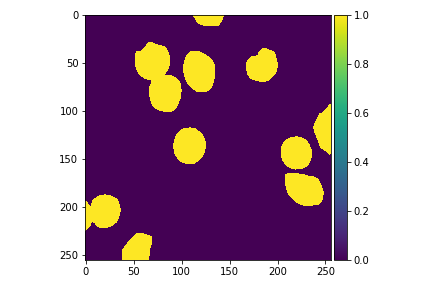
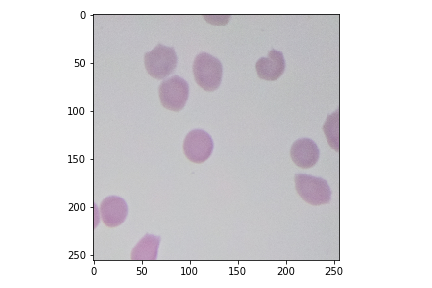
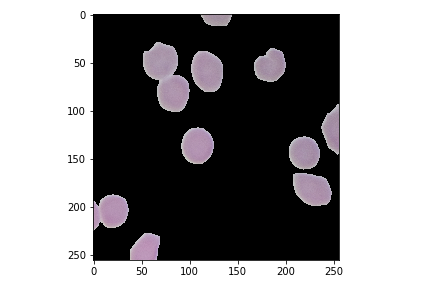

In [85]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

# Perform check on test set
ix = random.randint(0, len(pred_masks_t)-1)
oPlot.add_plot(imshow(np.squeeze(pred_masks_t[ix])))
plt.close() 
oPlot.add_plot(imshow(imgs_red[ix]))
plt.close() 
image_overlayed = np.where(np.squeeze(pred_masks_t[ix])[...,None], imgs_red[ix], 0)
oPlot.add_plot(imshow(image_overlayed)) # pass it to the FlowLayout to save as an image
plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()


In [86]:
num_labels, labels = cv2.connectedComponents(np.squeeze(pred_masks_t[ix]))

In [87]:
num_labels

11


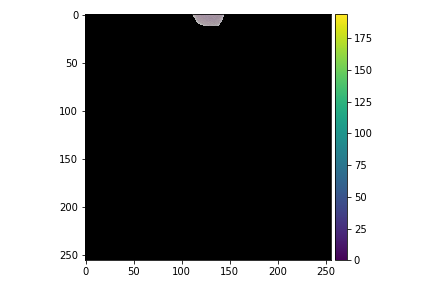
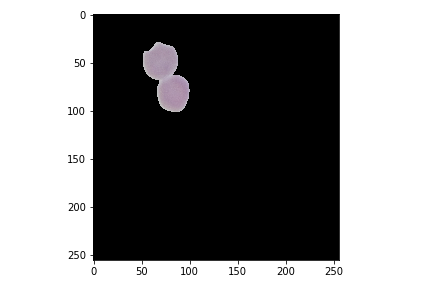
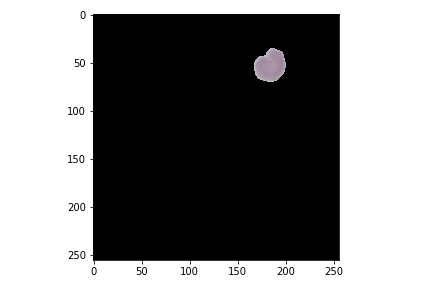
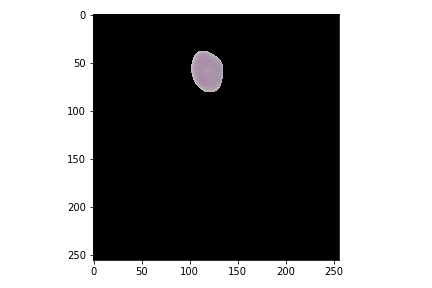
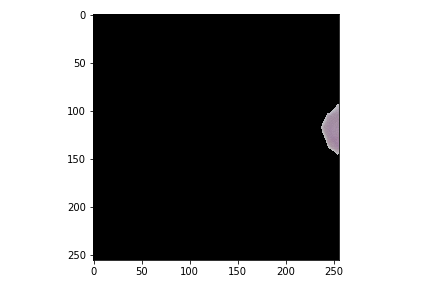
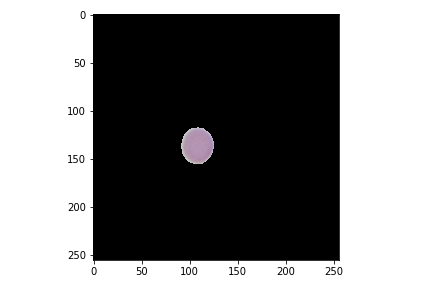
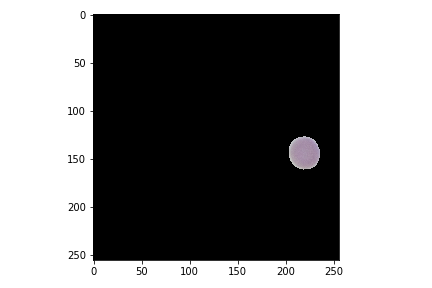
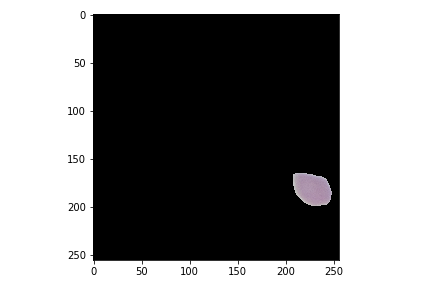
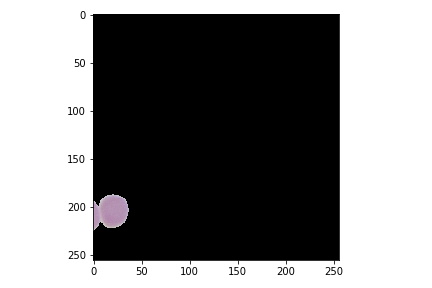
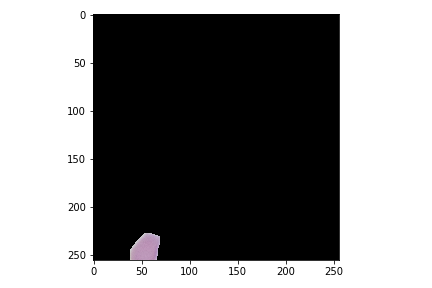

In [88]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs_red[ix], 0)
    oPlot.add_plot(imshow(component)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

# Yolo detect

In [89]:
yolo_model = load_model(yolo2_model, custom_objects={'SpaceToDepth': SpaceToDepth})

<Figure size 144x144 with 0 Axes>

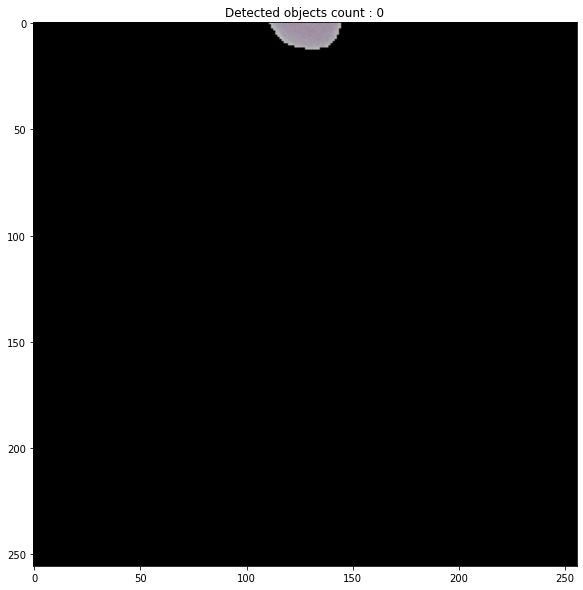

<Figure size 144x144 with 0 Axes>

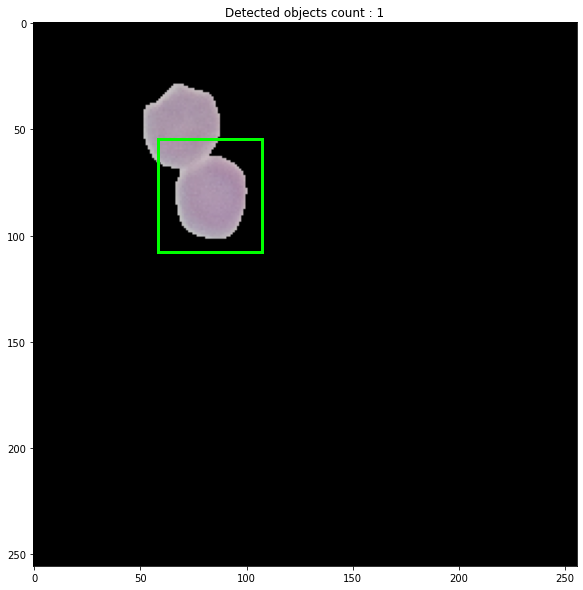

<Figure size 144x144 with 0 Axes>

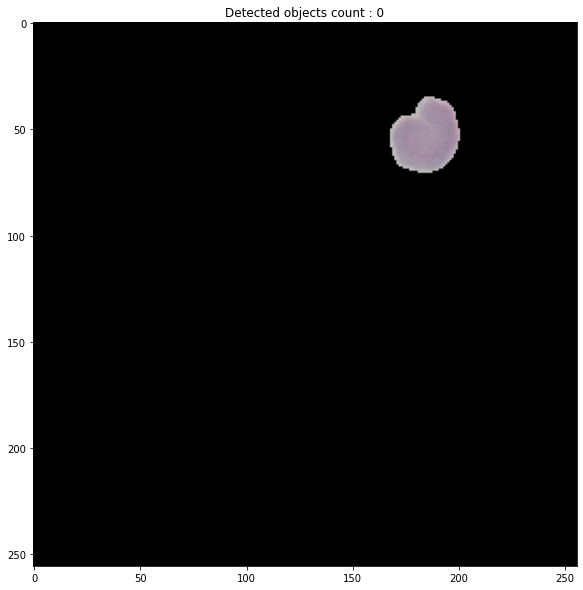

<Figure size 144x144 with 0 Axes>

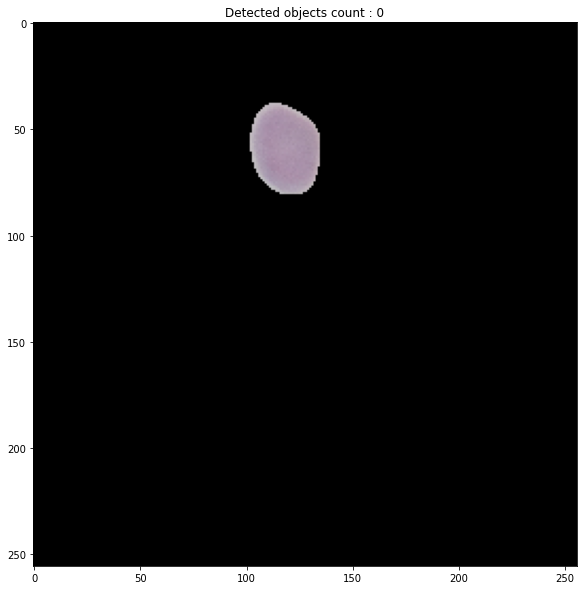

<Figure size 144x144 with 0 Axes>

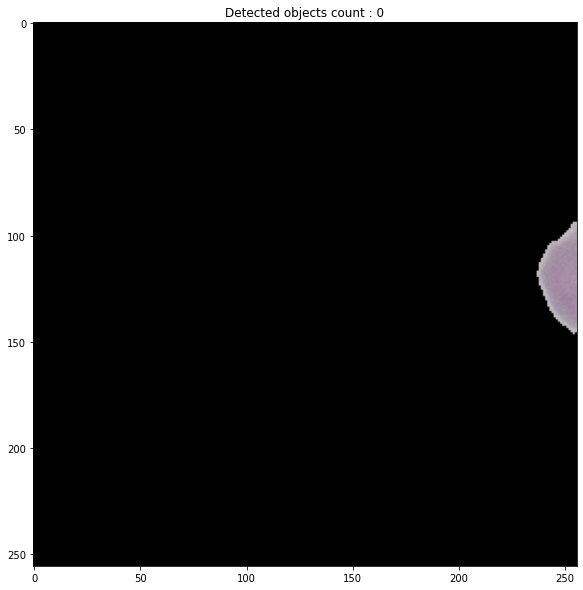

<Figure size 144x144 with 0 Axes>

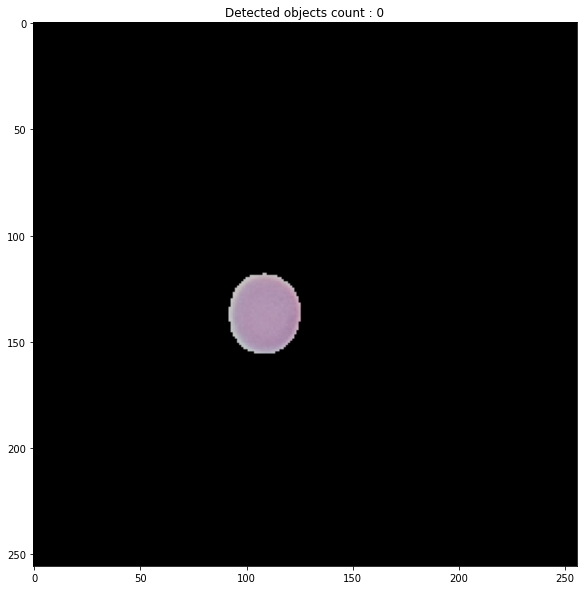

<Figure size 144x144 with 0 Axes>

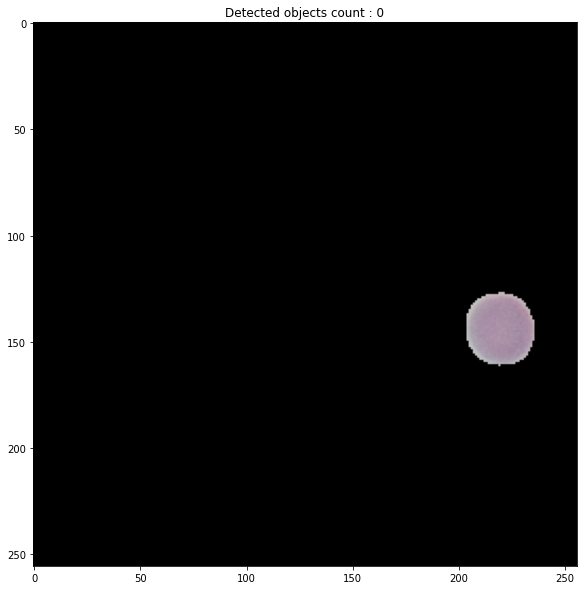

<Figure size 144x144 with 0 Axes>

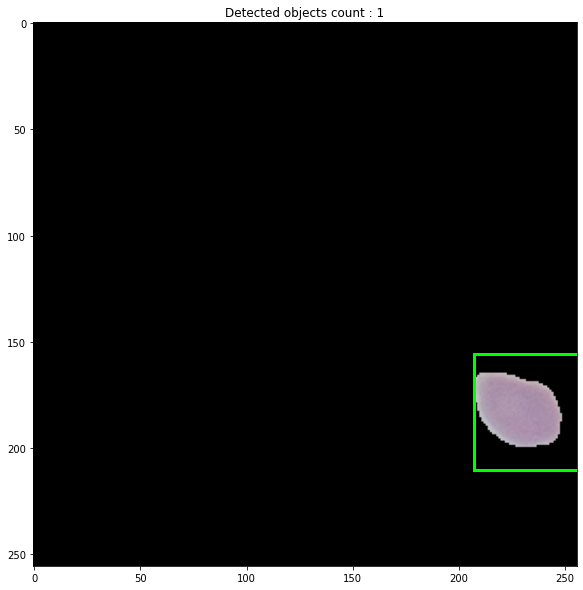

<Figure size 144x144 with 0 Axes>

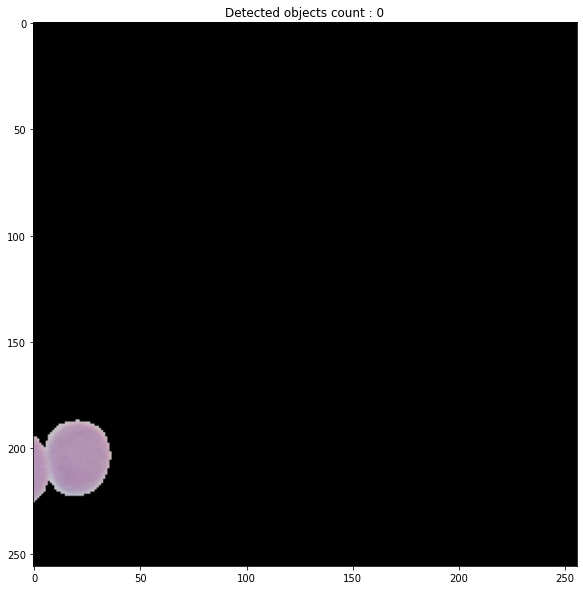

<Figure size 144x144 with 0 Axes>

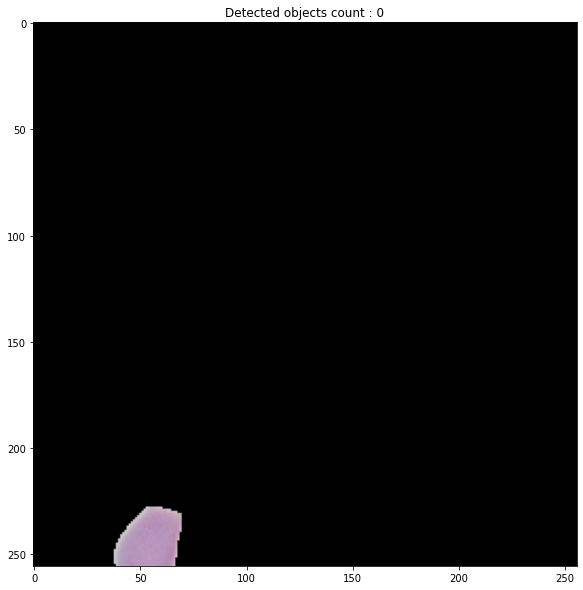

In [90]:
score_threshold  = 0.5
iou_threshold    = 0.45
for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs_red[ix], 0)
    pipeline.display_yolo(component, yolo_model, score_threshold, iou_threshold, plot = True)

<Figure size 144x144 with 0 Axes>

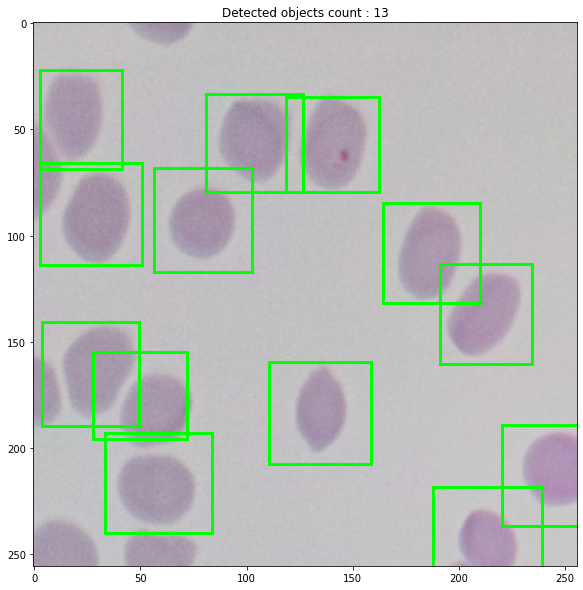

<Figure size 144x144 with 0 Axes>

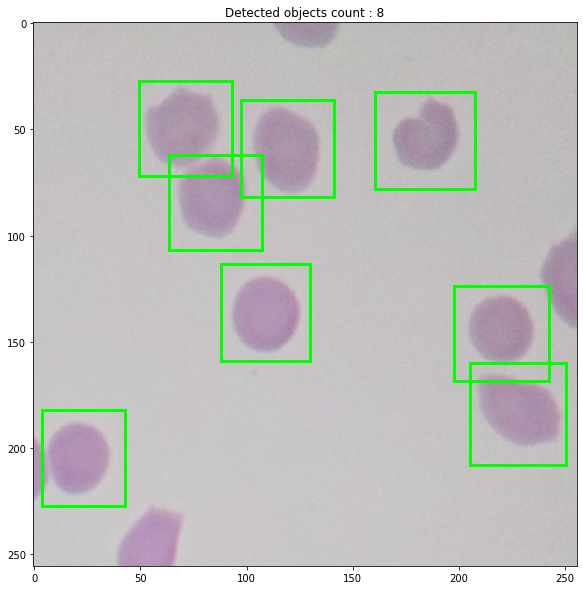

<Figure size 144x144 with 0 Axes>

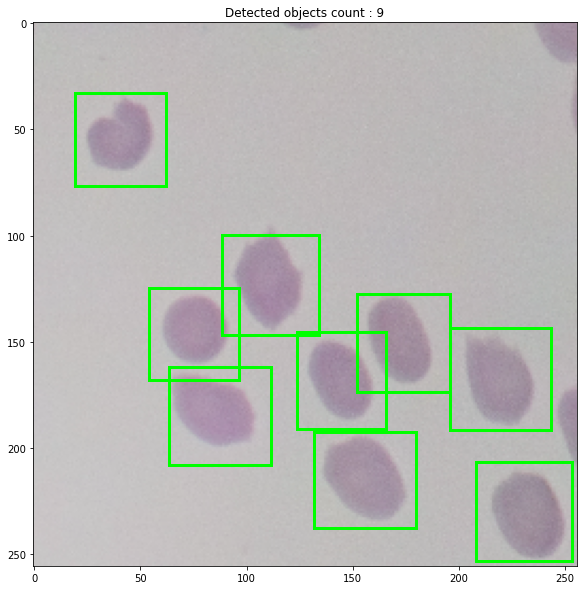

<Figure size 144x144 with 0 Axes>

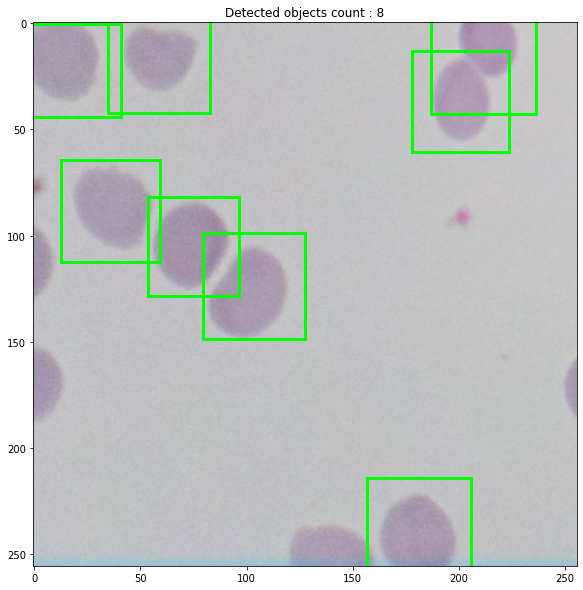

<Figure size 144x144 with 0 Axes>

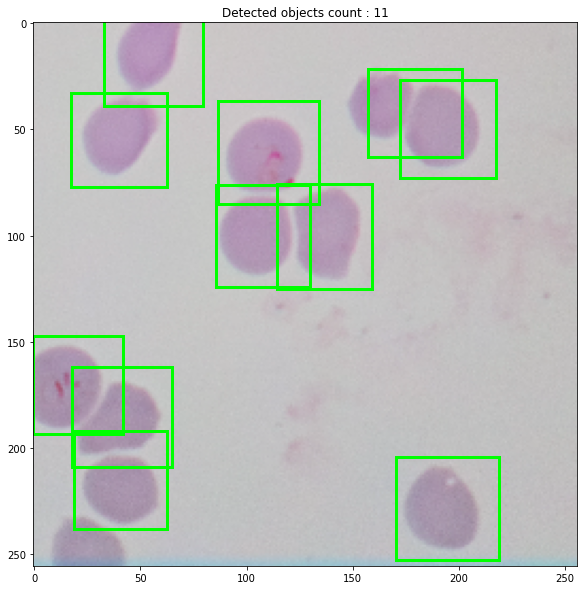

<Figure size 144x144 with 0 Axes>

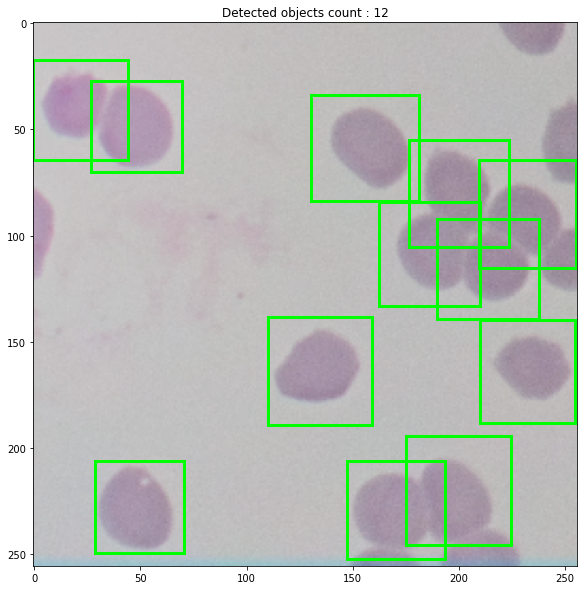

In [91]:
score_threshold  = 0.5
iou_threshold    = 0.45
results = []
for img in range(0, len(imgs_red)):
    boxes, scores, classes = pipeline.display_yolo(imgs_red[img], yolo_model, score_threshold, iou_threshold, plot = True)
    results.append([boxes, scores, classes])

In [92]:
for result in results:
    boxes, scores, classes = result
    boxes = boxes * 5 
    for box in boxes.numpy():
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2 = int(round(box[2]))
        y2 = int(round(box[3]))
        x1 = 0 if x1 < 0 else x1
        y1 = 0 if y1 < 0 else y1
        x2 = 0 if x2 < 0 else x2
        y2 = 0 if y2 < 0 else y2
    imgs_red[0][ y1:y2, x1:x2]

In [93]:
np.squeeze(pred_masks_t[0]).shape

(256, 256)

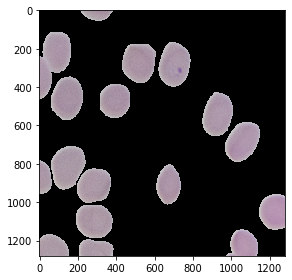

In [94]:
small_mask = np.squeeze(pred_masks_t[0])
big_mask = cv2.resize(small_mask, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
img_overlayed = np.where(big_mask[...,None], imgs[0], 0)
imshow(img_overlayed)

In [95]:
boxes, scores, classes = results[0]

In [96]:
boxes

<tf.Tensor: shape=(13, 4), dtype=float32, numpy=
array([[118.48889  ,  34.49457  , 162.5664   ,  79.69293  ],
       [  2.598877 ,  22.205215 ,  41.180416 ,  68.6296   ],
       [ 80.86865  ,  33.25001  , 126.47261  ,  79.241516 ],
       [164.0009   ,  84.78084  , 210.0077   , 131.6242   ],
       [191.16006  , 113.20646  , 234.6022   , 160.26978  ],
       [ 56.38853  ,  68.10056  , 102.68515  , 117.17608  ],
       [110.33107  , 159.58832  , 158.7617   , 207.39783  ],
       [  3.662468 , 140.55638  ,  49.338608 , 189.47688  ],
       [ 27.80719  , 154.96124  ,  71.881935 , 195.94635  ],
       [  2.9305077,  65.729675 ,  50.513012 , 114.07103  ],
       [ 33.280094 , 192.73598  ,  83.62953  , 239.9311   ],
       [220.25488  , 189.07082  , 264.4907   , 236.7274   ],
       [187.67441  , 218.16962  , 239.12262  , 265.66006  ]],
      dtype=float32)>

In [97]:
boxes = boxes * 5 
boxes

<tf.Tensor: shape=(13, 4), dtype=float32, numpy=
array([[ 592.44446 ,  172.47285 ,  812.83203 ,  398.46466 ],
       [  12.994385,  111.02608 ,  205.90208 ,  343.148   ],
       [ 404.34326 ,  166.25006 ,  632.36304 ,  396.20758 ],
       [ 820.0045  ,  423.90417 , 1050.0386  ,  658.12103 ],
       [ 955.8003  ,  566.0323  , 1173.011   ,  801.3489  ],
       [ 281.94266 ,  340.5028  ,  513.4258  ,  585.8804  ],
       [ 551.65533 ,  797.9416  ,  793.80853 , 1036.9891  ],
       [  18.31234 ,  702.7819  ,  246.69304 ,  947.3844  ],
       [ 139.03595 ,  774.8062  ,  359.40967 ,  979.73175 ],
       [  14.652538,  328.64838 ,  252.56506 ,  570.35516 ],
       [ 166.40047 ,  963.6799  ,  418.14764 , 1199.6555  ],
       [1101.2744  ,  945.35406 , 1322.4535  , 1183.637   ],
       [ 938.3721  , 1090.8481  , 1195.613   , 1328.3003  ]],
      dtype=float32)>

In [98]:
#make sure all the coordinates are at least 0
cropped_img =[]
for box in boxes.numpy():
    x1 = int(round(box[0]))
    y1 = int(round(box[1]))
    x2 = int(round(box[2]))
    y2 = int(round(box[3]))
    x1 = 0 if x1 < 0 else x1
    y1 = 0 if y1 < 0 else y1
    x2 = 0 if x2 < 0 else x2
    y2 = 0 if y2 < 0 else y2
    print( x1, x2, y1, y2)
    cropped_img.append(img_overlayed[ y1:y2, x1:x2])

592 813 172 398
13 206 111 343
404 632 166 396
820 1050 424 658
956 1173 566 801
282 513 341 586
552 794 798 1037
18 247 703 947
139 359 775 980
15 253 329 570
166 418 964 1200
1101 1322 945 1184
938 1196 1091 1328


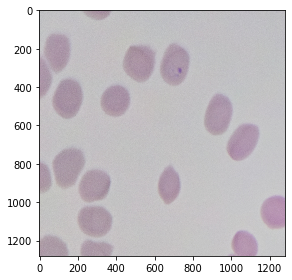

In [99]:
imshow(imgs[0])


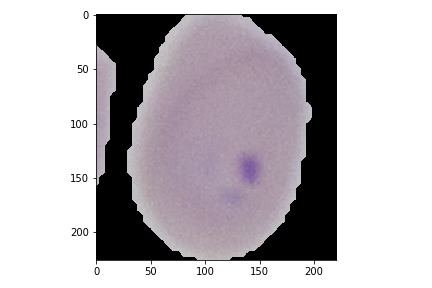
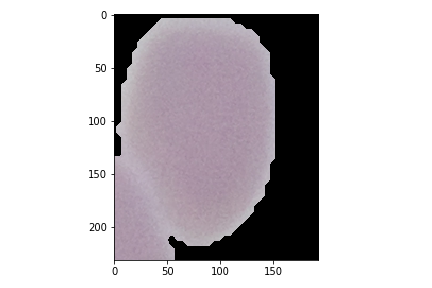
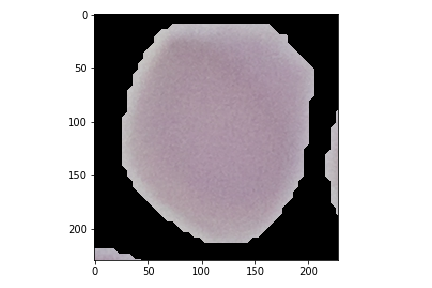
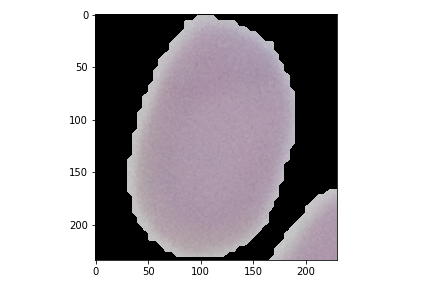
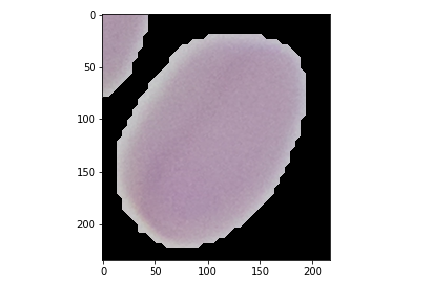
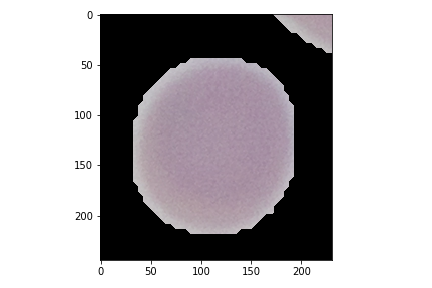
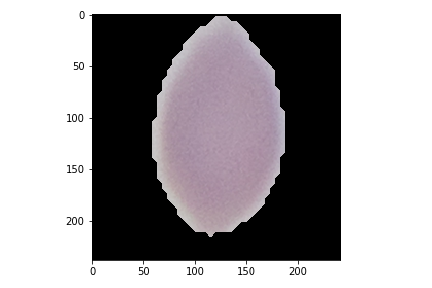
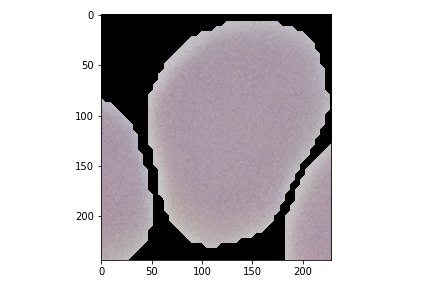
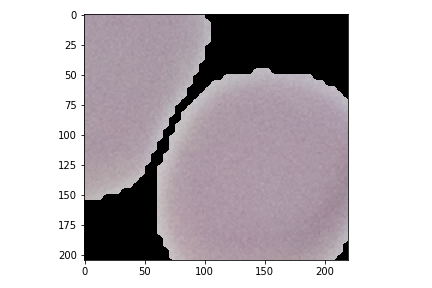
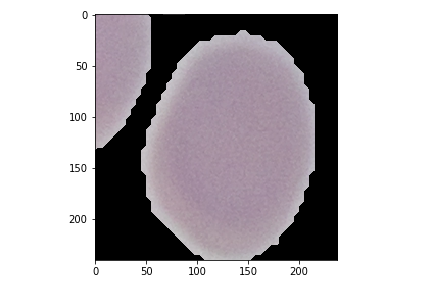
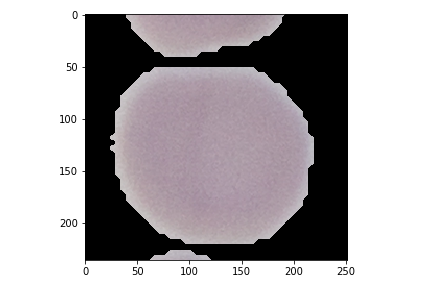
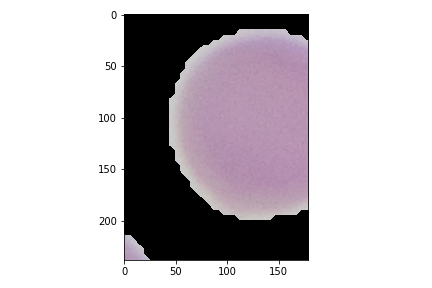
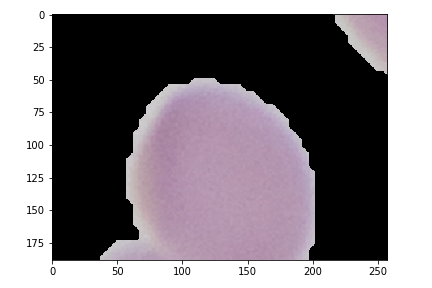

In [100]:

#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for img in cropped_img:
    oPlot.add_plot(imshow(img)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

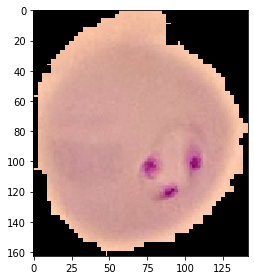

In [101]:
ref = '../data/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
ref_img  = imread(ref)
imshow(ref_img)

# Putting it all together to extract the images of the cells

In [ ]:
yolo_model = load_model(yolo2_model, custom_objects={'SpaceToDepth': SpaceToDepth})

for org_img_path in org_img_paths:
    pipeline.slice_img(org_img_path, output_dir_cut, resize_factor = 1,
                      slice_height = slice_height, slice_width = slice_width,
                      zero_frac_tresh = 0.8, overlap = 0, pad = 0, verbose = False)

img_paths = glob.glob(output_dir_cut)
imgs, sizes_imgs, img_paths = pipeline.get_imgs(path, img_height = slice_height, img_width = slice_width, img_channels = 3)

#reduced image sizes:
red_slice_height = 256
red_slice_width = 256
red_imgs, red_sizes_imgs, red_img_paths = pipeline.get_imgs(path, img_height = red_slice_height, img_width = red_slice_width, img_channels = 3)

# Unet predictions
pred_masks_t = pipeline.unet_predict(unet_model, red_imgs)

In [ ]:
for idx, (img, red_img, sizes_img, img_path) in enumerate(zip(imgs, red_imgs, sizes_imgs, img_paths)):
    
    img_name = os.path.basename(img_path)
    score_threshold  = 0.5
    iou_threshold    = 0.45
    boxes, scores, classes = pipeline.display_yolo(red_img, yolo_model, score_threshold, iou_threshold, plot = False)
    boxes = boxes * 5 
    
    small_mask = np.squeeze(pred_masks_t[idx])
    big_mask = cv2.resize(small_mask, dsize=(sizes_img[0], sizes_img[0]))
    img_overlayed = np.where(big_mask[...,None], img, 0)
   
    #make sure all the coordinates are at least 0
    for box in boxes.numpy():
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2 = int(round(box[2]))
        y2 = int(round(box[3]))
        x1 = 0 if x1 < 0 else x1
        y1 = 0 if y1 < 0 else y1
        x2 = 0 if x2 < 0 else x2
        y2 = 0 if y2 < 0 else y2
        cell_img_path = os.path.join(output_dir_cells + img_name) + '_' + str(x1) + '_' + str(y1) + '_' + str(x2) + '_' + str(y2) + '.jpeg'
        cell_img = img_overlayed[ y1:y2, x1:x2]
        cv2.imwrite(cell_img_path, cell_img)
        